## Predicting Volatility

In this project, we will attempt to build a machine learning model which predicts future realized volatility using historical volatility in relation to the mean volatility.

In [80]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Getting and transforming the data

In [81]:
#Get stock data
ticker = 'SPY'
data = web.DataReader(ticker, 'yahoo', start='1/1/1994')
data['pct change'] = data['Close'].pct_change()
data = data[['Close', 'pct change']]
data['pct change'].iloc[0] = 0
data

,Close,pct change
Date,,
1994-01-03,46.468750,0.000000
1994-01-04,46.656250,0.004035
1994-01-05,46.750000,0.002009
1994-01-06,46.750000,0.000000
1994-01-07,47.031250,0.006016
...,...,...
2022-09-06,390.760010,-0.003773
2022-09-07,397.779999,0.017965
2022-09-08,400.380005,0.006536


In [82]:
# Get annualized volatility data
rolling_periods = [252, 180, 90, 45, 30]

for period in rolling_periods:
    data[str(period)+'day_vol'] = data['pct change'].rolling(period).std() * np.sqrt(252)
data

,Close,pct change,252day_vol,180day_vol,90day_vol,45day_vol,30day_vol
Date,,,,,,,
1994-01-03,46.468750,0.000000,NaN,NaN,NaN,NaN,NaN
1994-01-04,46.656250,0.004035,NaN,NaN,NaN,NaN,NaN
1994-01-05,46.750000,0.002009,NaN,NaN,NaN,NaN,NaN
1994-01-06,46.750000,0.000000,NaN,NaN,NaN,NaN,NaN
1994-01-07,47.031250,0.006016,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-09-06,390.760010,-0.003773,0.211159,0.233776,0.258960,0.192976,0.200774
2022-09-07,397.779999,0.017965,0.211941,0.234299,0.257180,0.197283,0.204480
2022-09-08,400.380005,0.006536,0.212053,0.234155,0.250006,0.197644,0.190890


In [83]:
#Get 45 day future realized volatility data (annualized)
data = data.iloc[::-1]
data['45day future vol'] = data['pct change'].rolling(45).std() * np.sqrt(252)
data = data.iloc[::-1]
data = data.iloc[max(rolling_periods):len(data)-44] # Get rid of NaN values
data

C:\Users\Wyatt\AppData\Local\Temp\ipykernel_9644\3231313633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['45day future vol'] = data['pct change'].rolling(45).std() * np.sqrt(252)


,Close,pct change,252day_vol,180day_vol,90day_vol,45day_vol,30day_vol,45day future vol
Date,,,,,,,,
1995-01-03,45.781250,0.004801,0.106636,0.105059,0.114415,0.120877,0.112173,0.070337
1995-01-04,46.000000,0.004778,0.106667,0.104884,0.114657,0.109935,0.113180,0.069912
1995-01-05,46.000000,0.000000,0.106647,0.104875,0.112000,0.109732,0.109320,0.069508
1995-01-06,46.046875,0.001019,0.106653,0.104868,0.112024,0.106801,0.087716,0.076512
1995-01-09,46.093750,0.001018,0.106485,0.103696,0.111935,0.106089,0.086548,0.076730
...,...,...,...,...,...,...,...,...
2022-07-05,381.959991,0.001889,0.199136,0.223681,0.269693,0.305700,0.278843,0.192976
2022-07-06,383.250000,0.003377,0.199168,0.223515,0.268435,0.294223,0.279059,0.197283
2022-07-07,388.989990,0.014977,0.199723,0.224246,0.266962,0.296280,0.277040,0.197644


<AxesSubplot:xlabel='Date'>

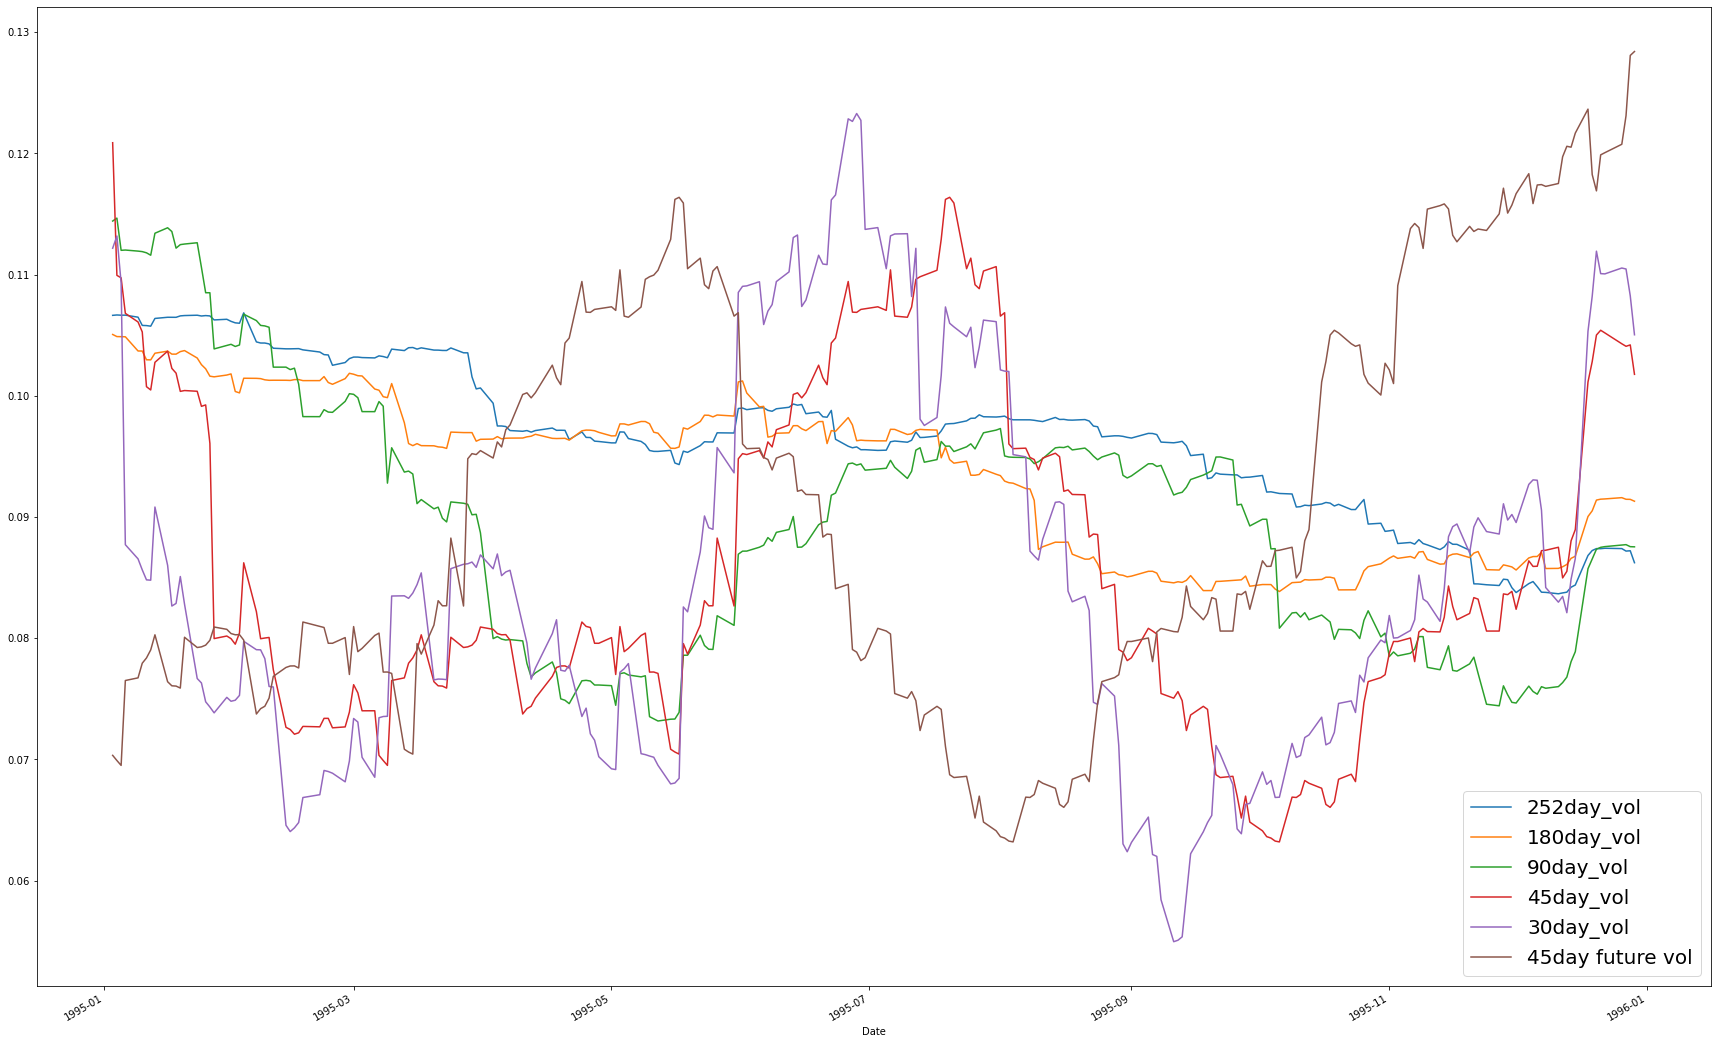

In [84]:
# Let's visualize a portion of the data
plt.rc('legend', fontsize=20)
(data.drop('Close', axis=1)).drop('pct change', axis=1).iloc[:252].plot(figsize=(30, 20))

Well I don't see anything here. Hopefully the model will.

## Model Time


In [85]:
# Get rid of Close and pct change
data = data.drop('Close', axis=1)
data = data.drop('pct change', axis=1)

In [86]:
# Break into train and test -- 8/10 to train
train = np.floor(len(data)*(8/10))
train = int(train)

X_train, y_train = data.drop('45day future vol', axis=1)[:train], data['45day future vol'][:train]
X_test, y_test = data.drop('45day future vol', axis=1)[train:], data['45day future vol'][train:]

# Import model and fit
from sklearn.ensemble import RandomForestRegressor

vol_model = RandomForestRegressor(random_state=42)
vol_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [87]:
vol_model.score(X_test, y_test)

-0.34960394518378246

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_preds = vol_model.predict(X_test)
mae = mean_absolute_error(y_test, y_preds)
mse = mean_squared_error(y_test, y_preds)

mae, mse

(0.08351146459647238, 0.01698481855920623)

Well, that sucks... let's see if it does any better cross-validated.

In [89]:
intervals = list(np.linspace(0, len(data), num=5))
intervals = [int(np.round(interval)) for interval in intervals]

r2 = []
mse = []
mae = []
for index, interval in enumerate(intervals):
    if index == 4: break
    datas = data[intervals[index]:intervals[index+1]]
    
    # Break into train and test -- 8/10 to train
    train = np.floor(len(datas)*(8/10))
    train = int(train)

    X_train, y_train = datas.drop('45day future vol', axis=1)[:train], datas['45day future vol'][:train]
    X_test, y_test = datas.drop('45day future vol', axis=1)[train:], datas['45day future vol'][train:]

    vol_model = RandomForestRegressor(random_state=42)
    vol_model.fit(X_train, y_train)
    
    y_preds = vol_model.predict(X_test)
    
    r2.append(r2_score(y_test, y_preds))
    mae.append(mean_absolute_error(y_test, y_preds))
    mse.append(mean_squared_error(y_test, y_preds))

In [90]:
np.mean(r2), np.mean(mae), np.mean(mse)

(-1.0822401096300673, 0.07765591209453099, 0.013968611960502359)